## Send MWA data to JSON format for training

In [70]:
import numpy as np
import os
import json
from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

In [45]:
# Get a bunch of sequential observations roughly centered around 1160763448, 
# since this one is known to contain RFI
center_obs = '1160763448_4165wcu_Pxx.hdf5'
mwa_path = '/users/jmduchar/data/shared/mwa_fall_16/dataset/all/'

sorted_filelist = np.sort([i for i in os.listdir(mwa_path) if 'Pxx' in i])
center_idx = np.where(sorted_filelist == center_obs)[0][0]

idx_range = np.arange(center_idx-20, center_idx+30)

idx_range

array([280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305,
       306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318,
       319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329])

In [46]:
pointing_zero_list = []  # append all files with pointing 0 (randomly chosen)

for file in sorted_filelist[idx_range]:
    
    obsid = file.split("_")[0]
    metapath = f"/users/jmduchar/data/shared/big_dataset/{obsid}.metafits"
    
    hdul = fits.open(metapath)
    obs_meta = hdul["PRIMARY"]
    if obs_meta.header['GRIDNUM'] == 0:
        pointing_zero_list.append(file)

In [62]:
cb = np.load('../data/coarse_bands_1D.npy')
ssins_list = []
for file in pointing_zero_list:
    with h5py.File(mwa_path+file, "r") as hf:
        capture_group = hf["capture"]

        # Metadata
        obsid = file.split('_')[0]
        pol = file.split('_')[-1].split(".")[0][1:]
#         print("OBSID:", obsid)
#         print("Polarization:", pol)
#         print("All HDF5 Keys:", capture_group.keys())

        # Access the SSINS
        ssins_rep = capture_group['ssins_rep'][:]
        
        # Remove CB
        ssins_rep = ssins_rep[:,np.invert(cb)]
        
        # Avg across DTV7
        ssins_rep = np.mean(ssins_rep[:,350:525], axis=1)
        
        # Append to list
        ssins_list.append(ssins_rep)

In [67]:
ssins = np.asarray(ssins_list).flatten()

ssins.shape

(848,)

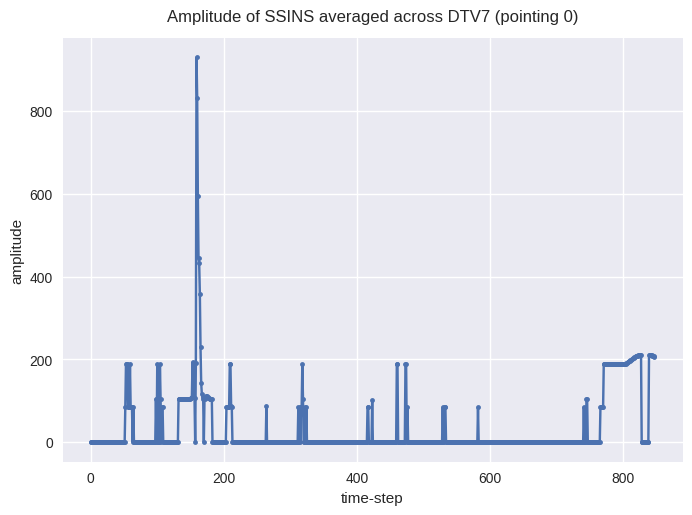

In [89]:
plt.plot(ssins, '.-')
plt.title("Amplitude of SSINS averaged across DTV7 (pointing 0)", y=1.02)
plt.xlabel("time-step")
plt.ylabel("amplitude")
# plt.ylim(-1,1)
plt.show()

In [97]:
# Structure the data for Stan
stan_data = {
    "T": ssins.shape[0],
    "y": ssins.tolist(),
    "mu0_clean": 0,  # prior on clean mean
    "sigma0_clean": 0.1,  # prior on clean std
    "mu0_rfi": 200,
    "sigma0_rfi":200,
}

In [98]:
stan_data

{'T': 848,
 'y': [-0.23089636852791026,
  -0.16967677940791454,
  -0.07799155654101561,
  -0.03237772419089683,
  -0.03099147867313787,
  -0.0874828617408101,
  -0.08227021831343076,
  0.1170372650462811,
  0.060592093086964526,
  -0.0037651611757830773,
  -0.0684933336703108,
  0.042978089141013316,
  -0.040767268730751864,
  -0.001102848932317512,
  0.03277984864341948,
  0.19319116550870105,
  0.052167746191250246,
  -0.04692117687449991,
  0.02135302761689136,
  0.030321806202099653,
  0.06147530250648997,
  0.03467660256683789,
  -0.08030759022156216,
  0.029692889188184562,
  0.1134992793295541,
  0.10332090564771462,
  0.08554338353158827,
  0.1165880621014135,
  0.1149448571726455,
  0.023397731459089584,
  0.03858879753476522,
  0.11457660584679928,
  0.10382839806412401,
  0.005129002958024844,
  0.0354019989134657,
  -0.0007202745785295948,
  0.14948763023014805,
  0.2364403895234115,
  0.005019263580172439,
  -0.00928696838455752,
  -0.03315013869880767,
  -0.04057157679561

In [99]:
# Write to JSON
with open("../data/two_state.data.json", "w") as f:
    json.dump(stan_data, f)